NOTEBOOK - LIMPIO

1 - IMPORTAMOS LIBRERIAS Y LEEMOS LOS DATOS

In [437]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns

pl.offline.init_notebook_mode(connected=True)
data= "../Data/properatti.csv"
propiedades= pd.read_csv(data)

COMENZAMOS CON LA LIMPIEZA DE DATOS


In [438]:
#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.state_name.value_counts()

Capital Federal    32316
Name: state_name, dtype: int64

In [439]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro
#SOLO DE MANERA INFORMATIVA
dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [440]:
#chequeamos la cantidad de valores faltantes en la columna price_usd_per_m2
#nos interesa ese campo ya que el precio en moneda local está sujeto a una tasa de cambio muy volatil 
#o inestables en el tiempo (tenemos la tasa de cambio a la fecha que se creo el DF pero no cuando se grabaron los datos 
#de cada propiedad), en este caso nos guiaremos por el valor en USD$ y el area o superficie de la propiedad
propiedades_capital.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64

In [441]:
#Columnas con pocos valores
i=0
for label, content in propiedades_capital.iteritems():
    num=len(pd.unique(propiedades_capital.iloc[:,i]))
    porcentaje=float(num)/propiedades_capital.shape[0]*100
    print("%s, %d, %.1f%%"%(label,num,porcentaje))
    propiedades_capital.iteritems()
    i=i+1


Unnamed: 0, 32316, 100.0%
operation, 1, 0.0%
property_type, 4, 0.0%
place_name, 62, 0.2%
place_with_parent_names, 62, 0.2%
country_name, 1, 0.0%
state_name, 1, 0.0%
geonames_id, 53, 0.2%
lat-lon, 14161, 43.8%
lat, 13885, 43.0%
lon, 13900, 43.0%
price, 5205, 16.1%
currency, 4, 0.0%
price_aprox_local_currency, 5295, 16.4%
price_aprox_usd, 5295, 16.4%
surface_total_in_m2, 751, 2.3%
surface_covered_in_m2, 618, 1.9%
price_usd_per_m2, 10877, 33.7%
price_per_m2, 11747, 36.4%
floor, 86, 0.3%
rooms, 19, 0.1%
expenses, 755, 2.3%
properati_url, 32316, 100.0%
description, 26094, 80.7%
title, 18144, 56.1%
image_thumbnail, 30255, 93.6%


In [442]:
#Observamos si hay filas duplicadas y de ser asi las eliminamos
duplicado = propiedades_capital.duplicated()
print(duplicado.any())
print(propiedades_capital[duplicado])
print(propiedades.shape)
propiedades.drop_duplicates(inplace=True)
print(propiedades.shape)

False
Empty DataFrame
Columns: [Unnamed: 0, operation, property_type, place_name, place_with_parent_names, country_name, state_name, geonames_id, lat-lon, lat, lon, price, currency, price_aprox_local_currency, price_aprox_usd, surface_total_in_m2, surface_covered_in_m2, price_usd_per_m2, price_per_m2, floor, rooms, expenses, properati_url, description, title, image_thumbnail]
Index: []

[0 rows x 26 columns]
(121220, 26)
(121220, 26)


In [443]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

place_name
Abasto              2057.529147
Agronomía           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [444]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [445]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().sum()

0

In [446]:
#hacemos un describe la columna price_usd_per_m2
propiedades_capital2.price_usd_per_m2.describe()

count     32316.000000
mean       3040.608512
std        3230.037746
min          13.797467
25%        2000.000000
50%        2495.288265
75%        3153.981976
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [447]:
#removemos los outliers de ese campo
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))

<AxesSubplot:xlabel='Barrios'>

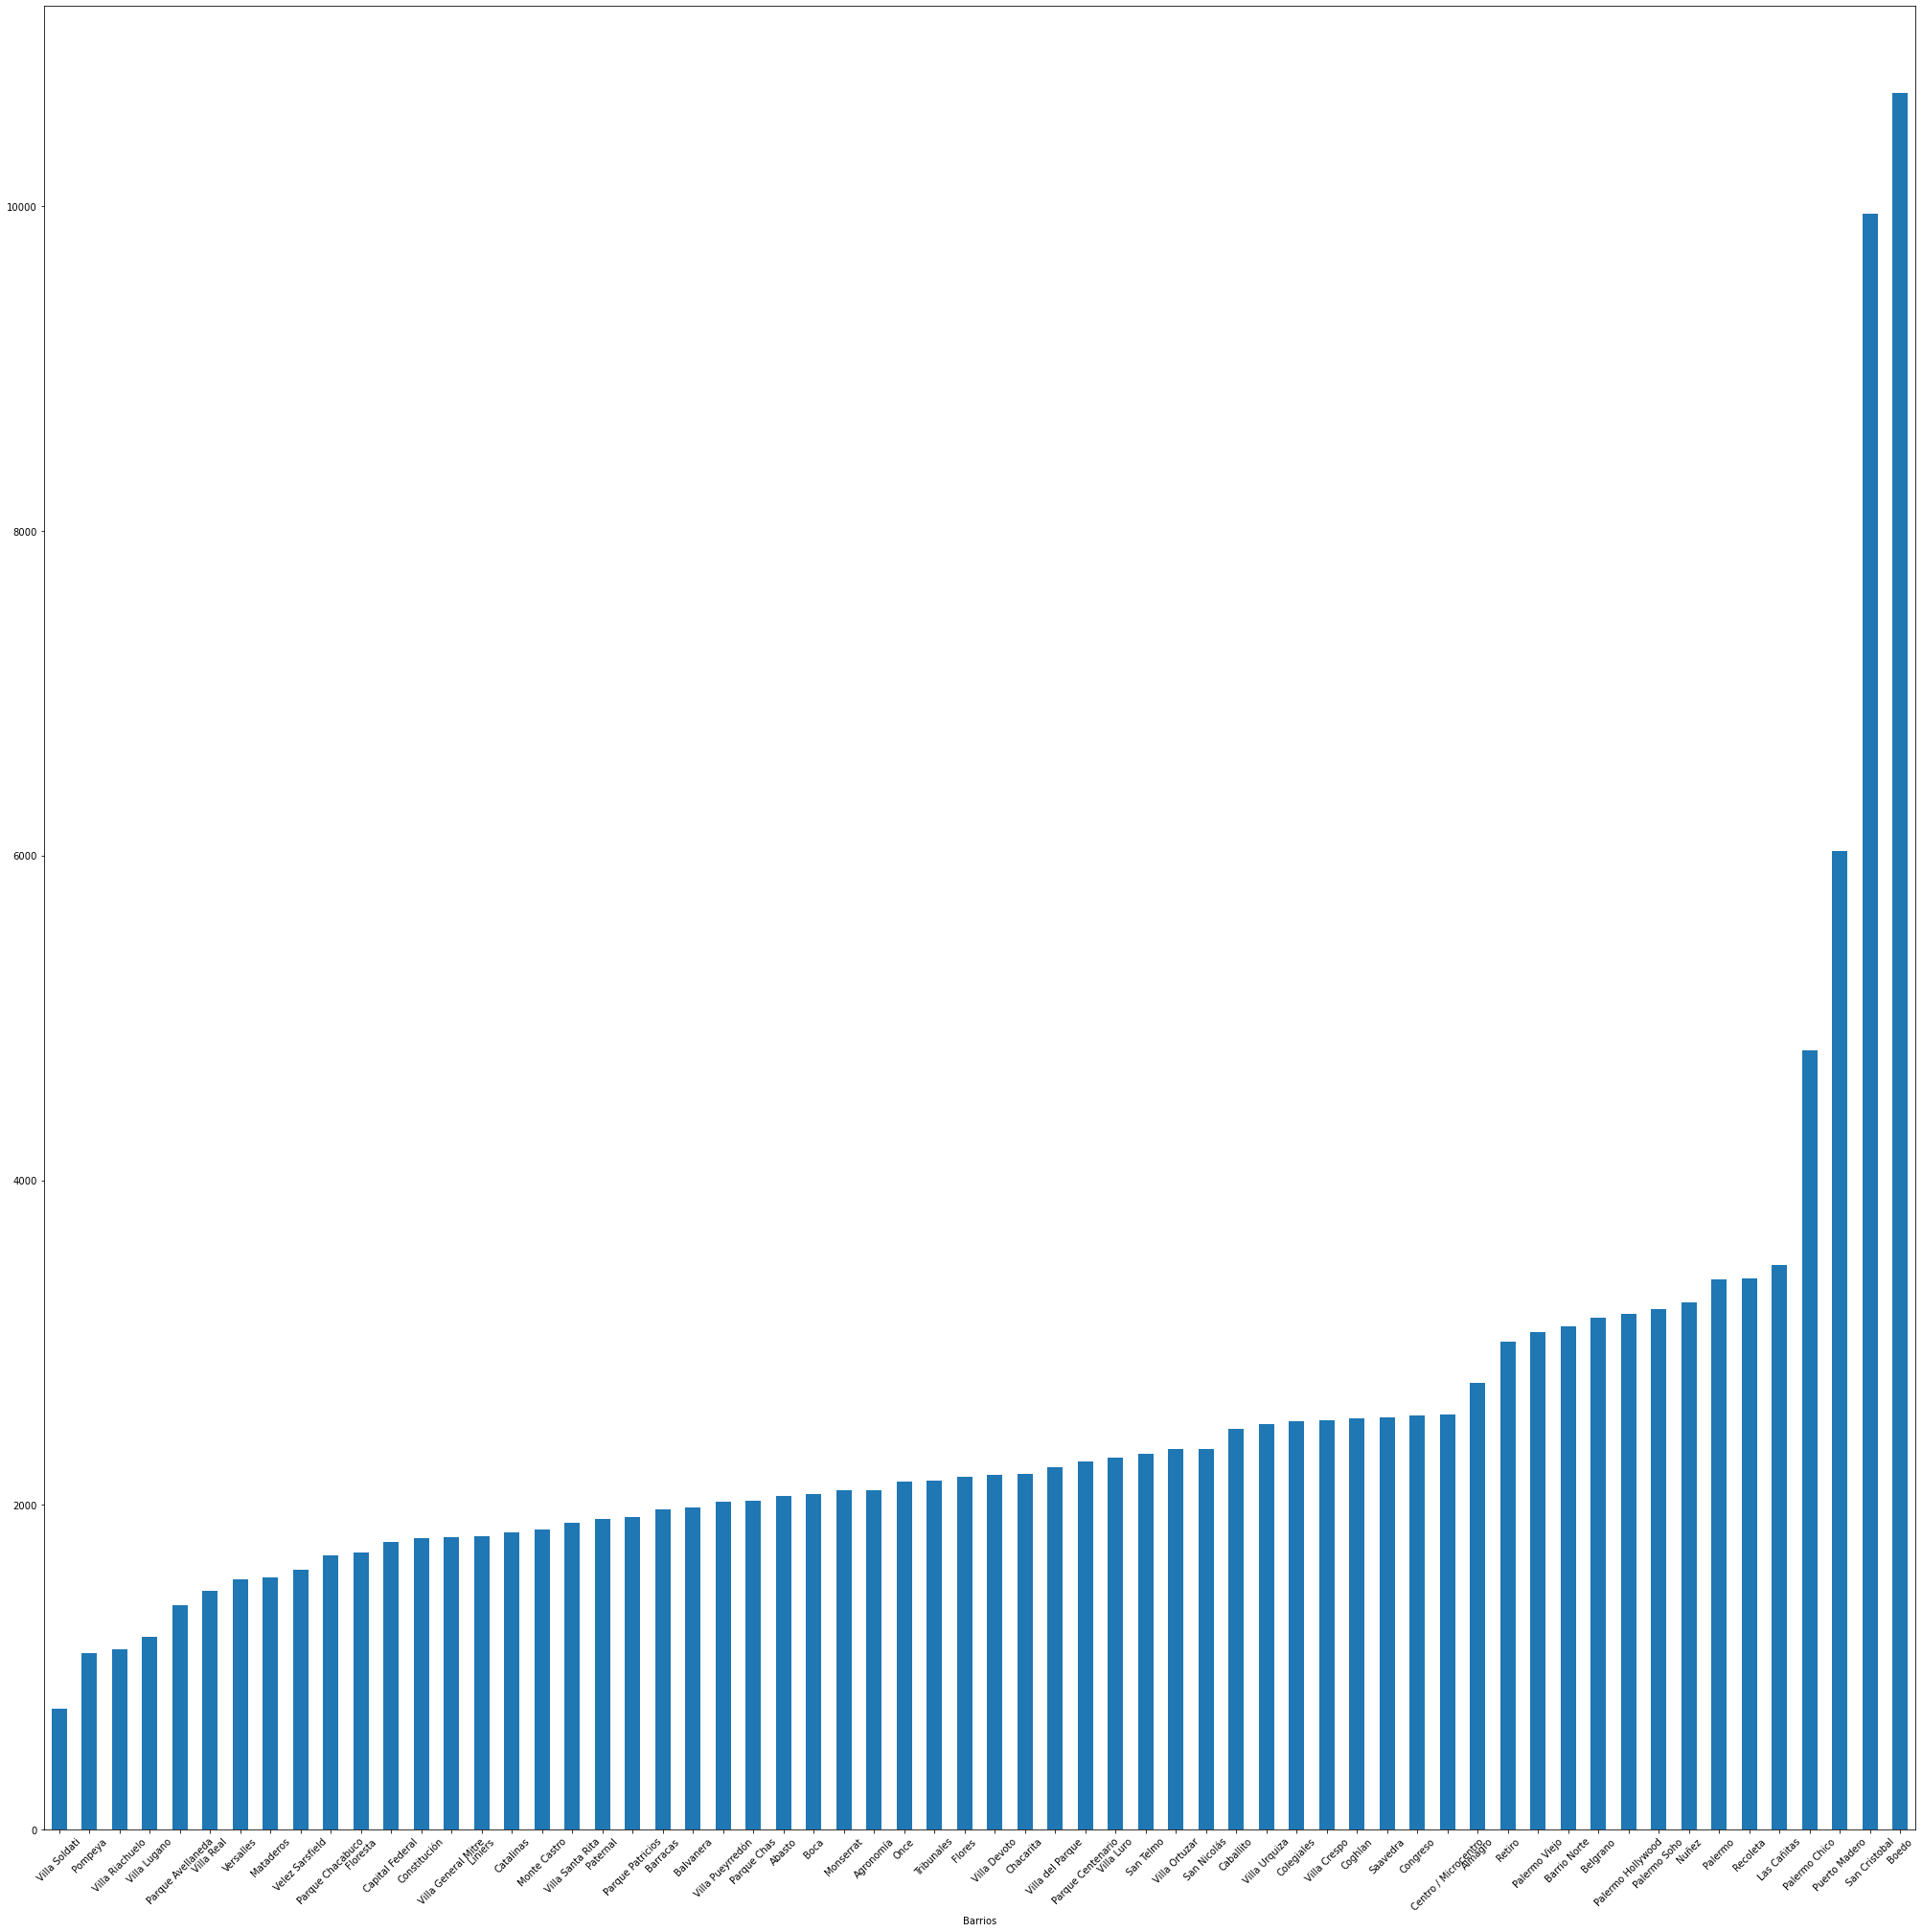

In [448]:
#graficamos el dataframe sin limpiar
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2.groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

<AxesSubplot:xlabel='Barrios'>

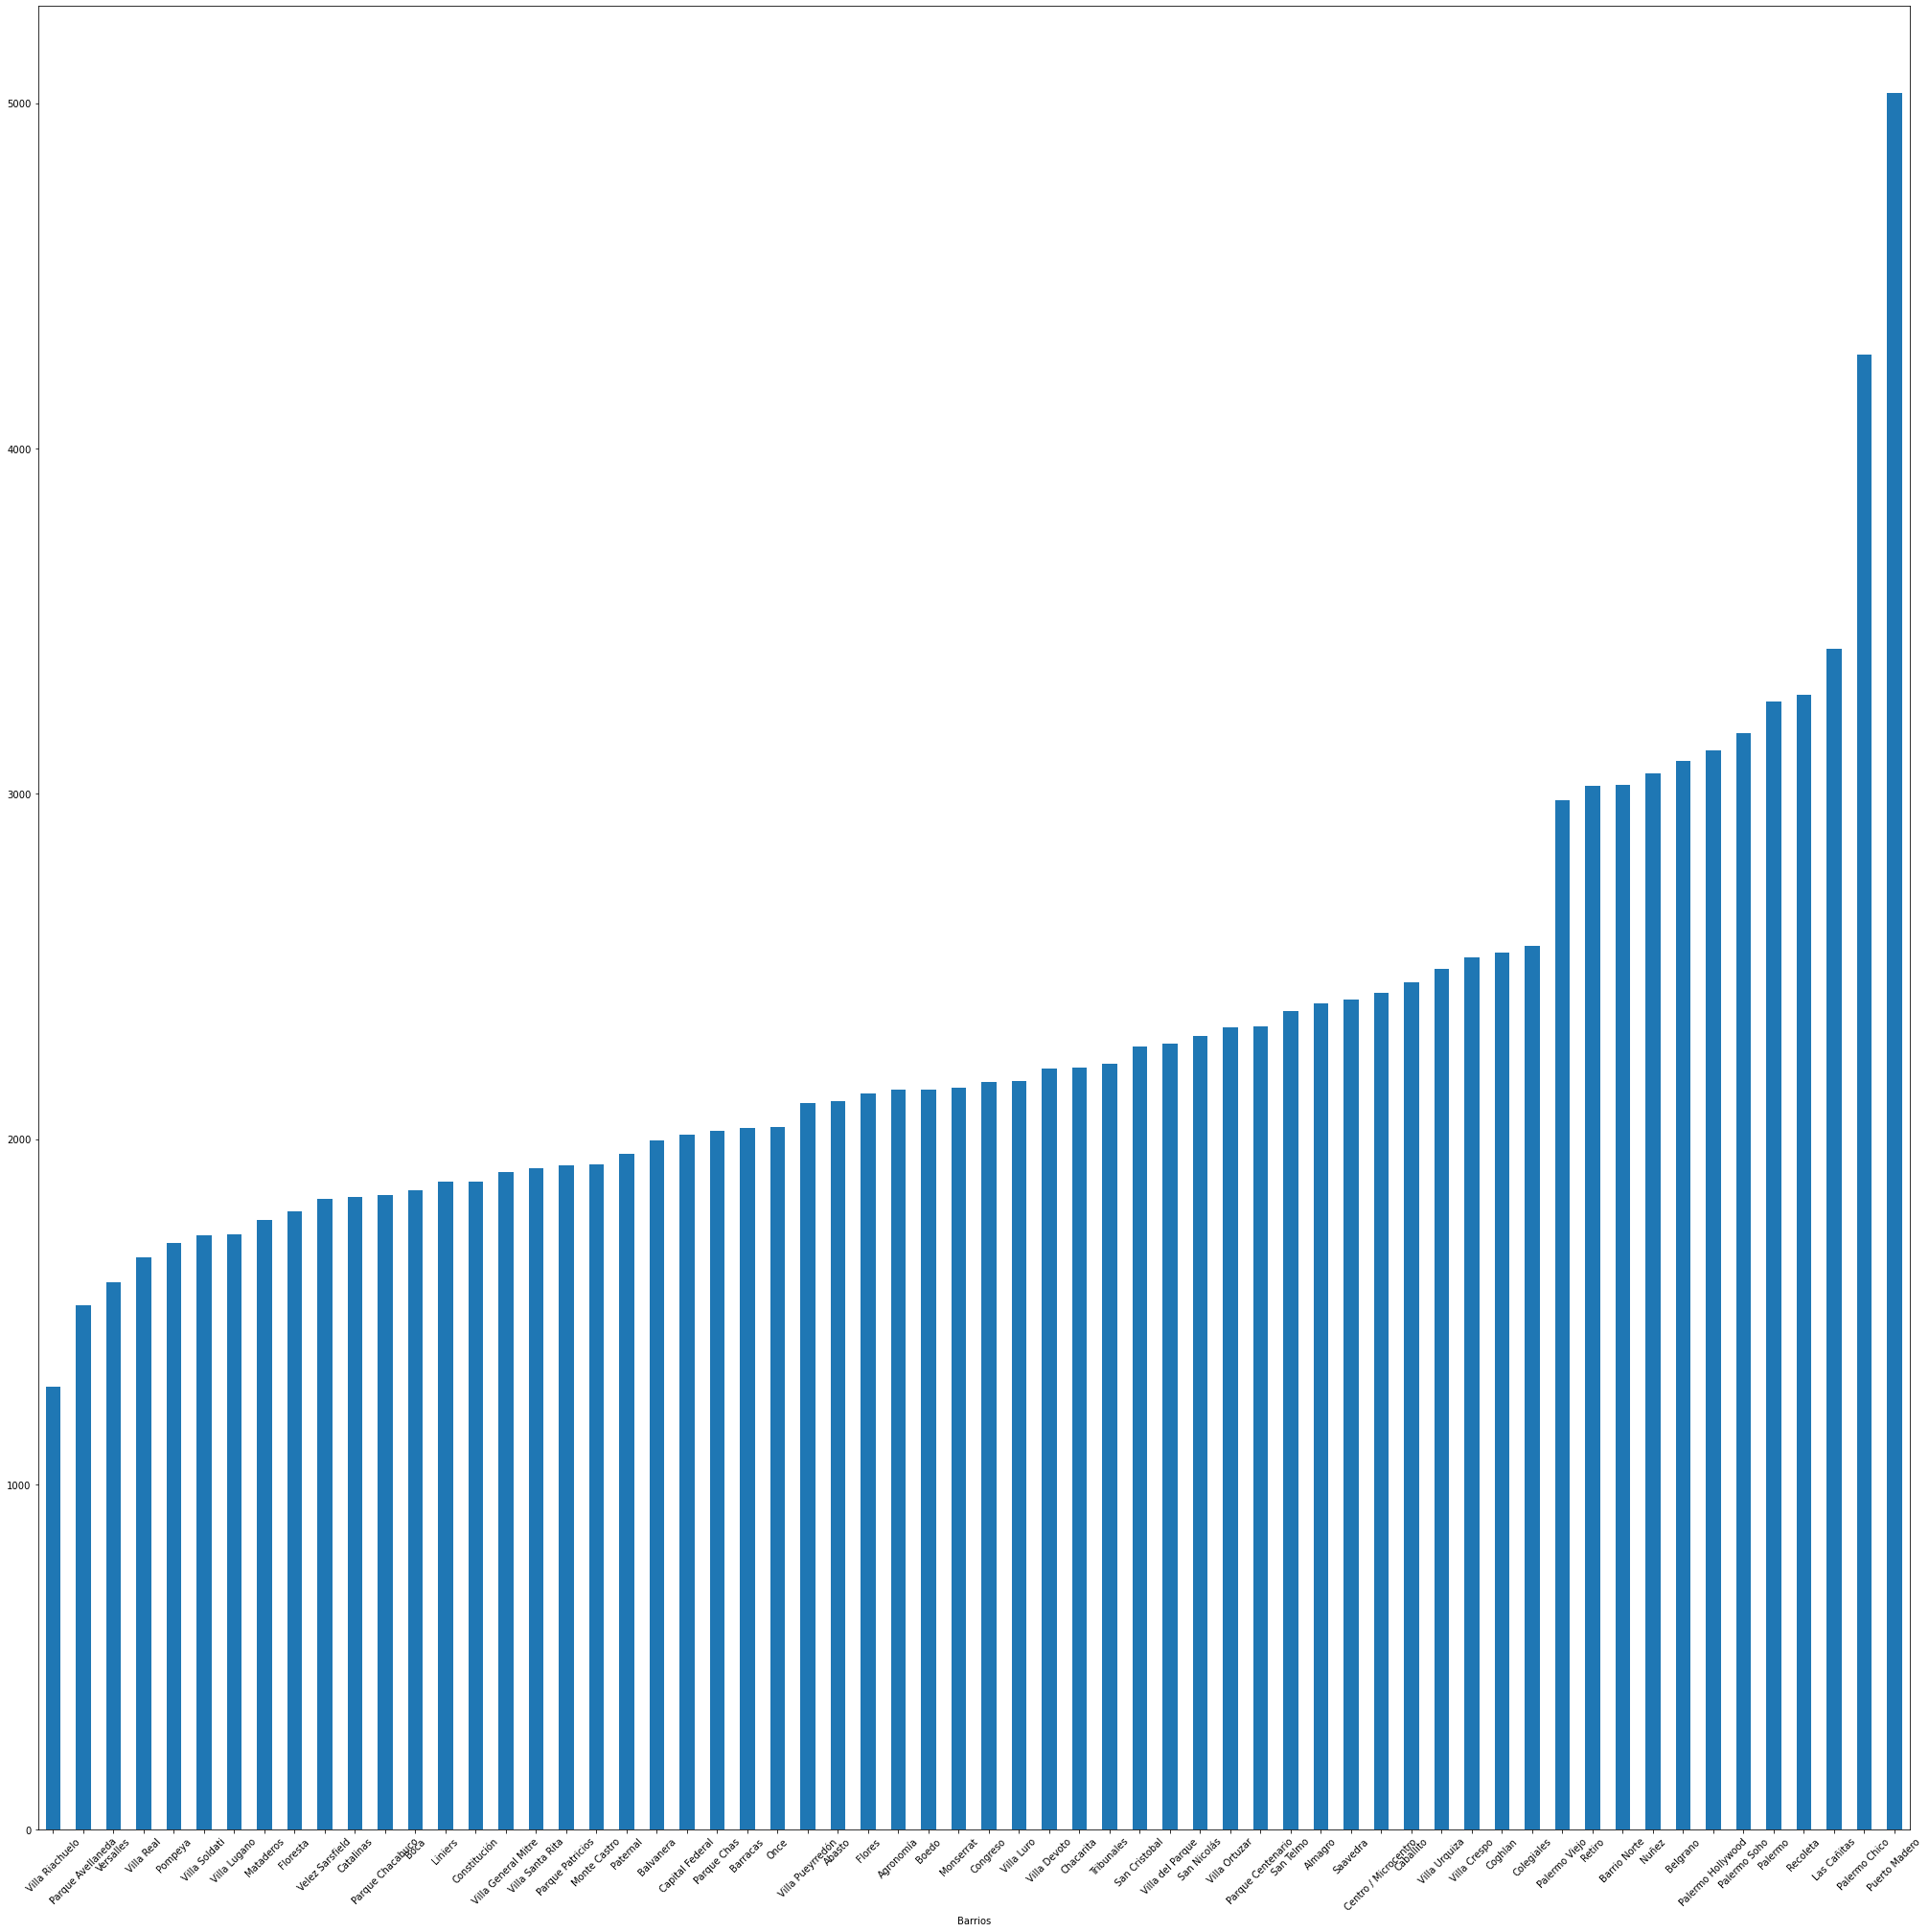

In [449]:
##graficamos el dataframe limpio
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [450]:
#revisamos cuales otras columnas faltan por datos
propiedades_capital2.isna().sum()


Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2                  0
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_usd_per_m2_mean             0
dtype: int64

In [451]:
#observamos que el campo un campo valioso para determinar el precio es el area de la propiedad
#en este caso no podriamos hacer un promedio, procedemos a removerla surface_covered_in_m2
propiedades_capital3=propiedades_capital2.dropna(axis=0,how='any',subset=['surface_covered_in_m2'])
propiedades_capital3.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1218
lat-lon                        7896
lat                            7896
lon                            7896
price                          2651
currency                       2651
price_aprox_local_currency     2651
price_aprox_usd                2651
surface_total_in_m2            5093
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                   2653
floor                         27075
rooms                         15120
expenses                      23825
properati_url                     0
description                       0
title                             0
image_thumbnail                 432
price_usd_per_m2_mean             0
dtype: int64

In [452]:
#funcion para extraer del campo description, el numero de ambientes o habitaciones
def limpieza_description(text):
    try:
        txt="(\d+(?=\s+dorm)|\d(?=\s+amb)|\d(?=\s+hab))"
        txt=txt.lower()
        x=int(re.findall(txt, text)[0])
        
    except IndexError:
        x="1"
    return(x) 

In [453]:
#creamos un df nuevo solo con casas y departamentos para poder limpiar la descripcion
propiedades_capital_casas_dptops=propiedades_capital3.loc[(propiedades_capital3.property_type=="apartment")|(propiedades_capital3.property_type=="house")|(propiedades_capital3.property_type=="PH")]

In [454]:
#creamos el patron REGEX para la busqueda de palabras como "dorm","amb" y "hab". Este patron buscará el primer numero 
#que consiga antes de alguna de esas palabras

pricem2USD_fill_values
propiedades_capital3['rooms_fill']=propiedades_capital3['description'].apply(lambda x: limpieza_description(x))

<ipython-input-454-475f6f71070f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [455]:
#propiedades_capital3.columns
propiedades_capital3[['description','rooms','rooms_fill']].sample(5)

,description,rooms,rooms_fill
1181,Colegiales PH 5 ambientes. Entrada independien...,5.0,5
12687,PISO 6°C. Hermoso departamento (apto profesion...,1.0,0
11692,Corredor Responsable: Mauro Marvisi - CUCICBA ...,1.0,1
24223,Evoque Olazábal es un edificio para vivir y tr...,NaN,4
14411,Excelente zona proxima al parque las heras. El...,3.0,2


In [456]:
#Inputamos los valores Nan de la columna rooms, usando los valores de rooms_fill que obtuvimos de la ultima ejecucion
propiedades_capital3.rooms.fillna(propiedades_capital3.rooms_fill, inplace = True)
propiedades_capital3.dtypes

C:\Users\Edgar\.conda\envs\dhdsblend2021\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                          object
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [457]:
#Seleccionamos las columnas que nos resultan utiles para un modelo posterior
propiedades_capital_limpio=propiedades_capital3[['property_type','place_name','price','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2',
       'surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','description','price_usd_per_m2_mean']]
propiedades_capital_limpio.rooms=propiedades_capital_limpio.rooms.astype(np.float)

C:\Users\Edgar\.conda\envs\dhdsblend2021\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



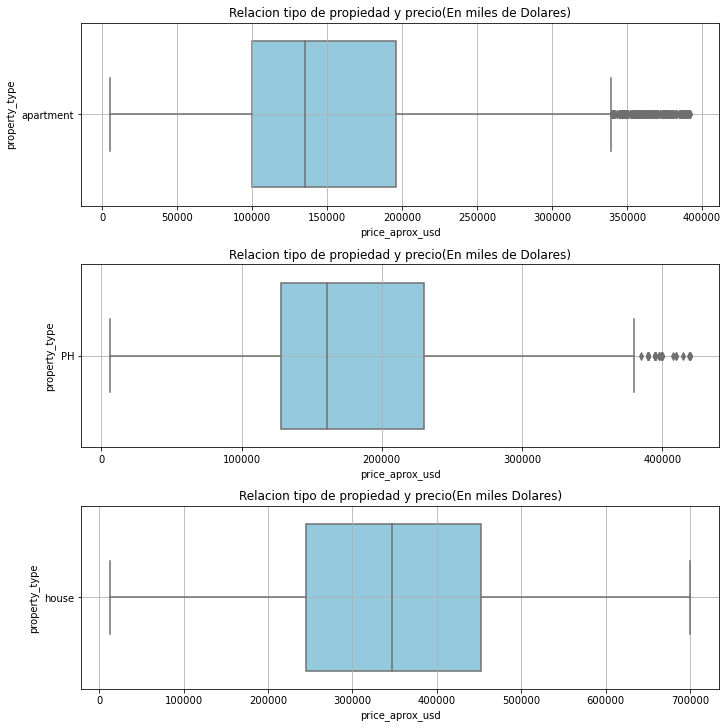

In [458]:
#Utilizamos estos boxplot para analizar la relacion entre los tipos de propiedad y los precios en dolares
propiedades_capital_limpio=propiedades_capital_limpio.dropna(axis=0,how='any',subset=['price_aprox_usd'])
dptos=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="apartment"]
phs=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="PH"]
casas=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="house"]
dptos= dptos[(dptos.price <= 392500.0) & (dptos.price >=65000.0) ]
phs=phs[(phs.price <= 428500.0) & (phs.price >=75000.0) ]
casas=casas[(casas.price <= 706000.0) & (casas.price >=110000.0) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax2.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax3.set_title("Relacion tipo de propiedad y precio(En miles Dolares)")
sns.boxplot(data=dptos,x="price_aprox_usd",y="property_type",ax=ax1, color='skyblue')
sns.boxplot(data=phs,x="price_aprox_usd",y="property_type",ax=ax2, color='skyblue')
sns.boxplot(data=casas,x="price_aprox_usd",y="property_type",ax=ax3, color='skyblue')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [459]:
#porcentaje de valores nulos por columna
col_null_caba=np.sum(propiedades_capital_limpio.isnull())
col_null_caba.sort_values(ascending=False)
porc_nulos_caba=np.round((col_null_caba/propiedades_capital_limpio.shape[0])*100,2)
porc_nulos_caba.sort_values(ascending=False)


floor                         89.54
surface_total_in_m2           18.32
price_per_m2                   0.01
price_usd_per_m2_mean          0.00
description                    0.00
rooms                          0.00
price_usd_per_m2               0.00
surface_covered_in_m2          0.00
price_aprox_usd                0.00
price_aprox_local_currency     0.00
price                          0.00
place_name                     0.00
property_type                  0.00
dtype: float64

In [460]:
propiedades_capital_surface_covered_fill=propiedades_capital_limpio.groupby('place_name').surface_covered_in_m2.mean()
propiedades_capital_limpio_surface_total_fill=propiedades_capital_limpio.groupby('place_name').surface_total_in_m2.mean()
propiedades_capital_surface=propiedades_capital_limpio_surface_total_fill/propiedades_capital_surface_covered_fill

In [461]:
propiedades_capital_surface_fill_pd=pd.DataFrame(propiedades_capital_surface)
propiedades_capital_surface_fill_pd.reset_index(inplace=True)
propiedades_capital_surface_fill_pd.columns=['place_name','surface_mean']
propiedades_capital_surface_limpio=propiedades_capital_limpio.merge(propiedades_capital_surface_fill_pd, on='place_name', how='left',suffixes = ("", "_mean"))


In [462]:
propiedades_capital_surface_limpio.rename(columns={'0': 'surface_mean'})
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean'],
      dtype='object')

In [463]:
surface_total_in_m2 = propiedades_capital_limpio['surface_total_in_m2'].mean()
surface_total_in_m2
surface_covered_in_m2 = propiedades_capital_limpio['surface_covered_in_m2'].mean()
surface_covered_in_m2 
surface_covered_in_m2 * 100 / surface_total_in_m2

88.26944144005208

In [464]:
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio[removed_outliers_surface_limpio]

<ipython-input-464-779a35734c55>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
dptos= dptos[(dptos.surface_total_in_m2 <= 182.91) & (dptos.surface_total_in_m2 >=26.0) ]
phs=phs[(phs.surface_total_in_m2 <= 275.0) & (phs.surface_total_in_m2 >=35.0) ]
casas=casas[(casas.surface_total_in_m2 <= 583.12) & (casas.surface_total_in_m2 >=56.81) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y superficie total")
ax2.set_title("Relacion tipo de propiedad y superficie total")
ax3.set_title("Relacion tipo de propiedad y superficie total")
sns.boxplot(data=dptos,x="surface_total_in_m2",y="property_type",ax=ax1)
sns.boxplot(data=phs,x="surface_total_in_m2",y="property_type",ax=ax2)
sns.boxplot(data=casas,x="surface_total_in_m2",y="property_type",ax=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [ ]:

plt.figure(figsize=(10,5))
from matplotlib.ticker import ScalarFormatter

plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = propiedades_capital_surface_limpio, x = "property_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")


plt.show()

In [ ]:
#Realizamos un heatmap para observar el grado de correlacion entre las variables
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades_capital_surface_limpio.corr(), annot=True)